# Model Evaluation / Comparison

In [1]:
import torch
from tools import plot_column_from_csv, load_model, torcherize_batch, get_data_loader
from tokenizer import get_tokenizer

In [2]:
models_to_compare = [
    '5foot11_and_skinnyfat',
    'short_and_thick'
]

### first up we'll look at loss curves
notice that even with a log scale I had to splice out the first 10% to make the lines distinct

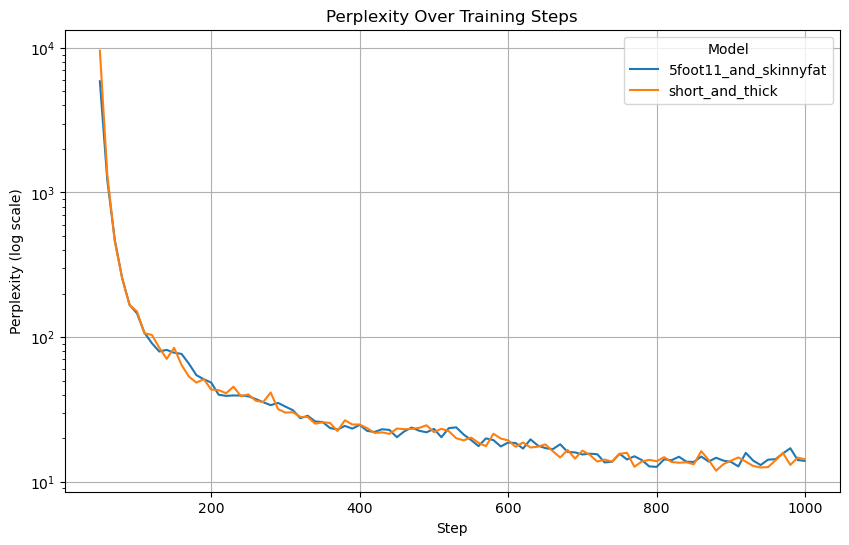

In [3]:
plot_column_from_csv(models_to_compare, 'Step', 'Perplexity', log_y=True, trim_percentage=5)

### now let's compare individual token accuracies

In [52]:
batch_size = 1 # can only be 1 until i fix batched inference
topk = 5

In [38]:
# Data preparation
data_loader = get_data_loader(batch_size=batch_size, split='validation')
text = next(iter(data_loader))
tokenizer = get_tokenizer(2048)
x, y = torcherize_batch(tokenizer, text)  # x and y are tensors shape [batch_size, 512] of dtype torch.int64

# we want to make sure to choose a y value that takes advantage of the full context
print(y)

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


tensor([[1663,  485, 1985,   73,  325,   96, 1461,  978,  374, 1209,  121,   82,
          647,   79,  241,   99,   52,  121,    2,  977,  181,   98,  153, 1901,
         1255,  146,  536,  677,  153,  281,    2,  109,   88,   99,   52,  121,
            2,  178,  611, 1727,  647,   79,  241,  647, 1044,  677, 1255,  607,
           78,   99,   52,  121,    2, 1117, 1037,  235,   85,   96,  276,  121,
           82,  647,   79,  241,  119,  217, 1916,   89,  108, 1663,  485,  153,
          339,  124,  181,  153,  281,  406, 1204,  725,    2,  192,  144,    2,
           75,  958,  114,   99,  267, 1117,   98, 1037,  886,   99,  503,  149,
          554,  136,   65,  325,   96,  184, 1345,   95,  224, 1600, 1295,  102,
          677, 1255,  110,  583,  493,   78,   99, 1663,  485, 1985,   79,  549,
           96, 1345,   69,   99,   52,  121,    2,  197, 1667,   96,  184,   83,
          164,  441,  119,   52,  121,    2,  562,   78,  100,  789,  121,    2,
           75,  958,  213,  

In [39]:
# Function to calculate top-k accuracy
def calculate_topk_accuracy(logits, targets, k=5):
    topk_indices = torch.topk(logits, k, dim=2).indices
    correct = topk_indices.eq(targets.unsqueeze(2).expand_as(topk_indices))
    return correct.any(dim=2).float().mean()

In [53]:
# Evaluate models
results = {}
for model_name in models_to_compare:
    model, _, _ = load_model(model_name)
    model.eval()
    with torch.no_grad():
        logits, _ = model(x)
    
    topk_accuracy = calculate_topk_accuracy(logits, y, k=topk)
    topk_values, topk_indices = torch.topk(logits, topk, dim=2)
    
    # Store results
    results[model_name] = {
        'accuracy': topk_accuracy.item(),
        'topk_indices': topk_indices,
        'topk_values': topk_values
    }

ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=8, second_resid_norm=False, mlp_hidden_mult=2, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=8, num_kv_heads=2, head_dim=16, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 493.888 K parameters
ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=4, second_resid_norm=False, mlp_hidden_mult=4, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=16, num_kv_heads=4, head_dim=16, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 492.864 K parameters


In [58]:
# Example of accessing and displaying the results for each model
for name, data in results.items():
    print(f"Model: {name}, Top-{topk} Accuracy: {data['accuracy']*100:.2f}%")
    #print(f"Top prediction for each token in the sequence: {data['topk_indices'][:,:,0]}")
    print(f"Top-{topk} predictions for the last token: {data['topk_indices'][:,-1,:]}")
    

Model: 5foot11_and_skinnyfat, Top-5 Accuracy: 62.50%
Top-5 predictions for the last token: tensor([[178, 121, 270, 184,  72]])
Model: short_and_thick, Top-5 Accuracy: 65.62%
Top-5 predictions for the last token: tensor([[ 72, 178, 270, 121, 115]])
